In [ ]:
#predicting fraud detection

In [1]:
rdd_data = sc.textFile("/user/centos/ccFraud.csv")

In [2]:
header = rdd_data.persist().take(1) #gives list

In [3]:
header

[u'"custID","gender","state","cardholder","balance","numTrans","numIntlTrans","creditLine","fraudRisk"']

In [4]:
header1 = rdd_data.first()

In [5]:
header1

u'"custID","gender","state","cardholder","balance","numTrans","numIntlTrans","creditLine","fraudRisk"'

In [6]:
#each of the element in this data-set has "" in it. so be careful of it;
#convert it into dataframe;
import pyspark.sql.types as typ

In [15]:
header[0]

u'"custID","gender","state","cardholder","balance","numTrans","numIntlTrans","creditLine","fraudRisk"'

In [7]:
struct_fields = [typ.StructField(col[1:-1],typ.IntegerType(),True) for col in header1.split(",")]

In [8]:
schema = typ.StructType(struct_fields)

In [18]:
rdd_data.take(10)

[u'"custID","gender","state","cardholder","balance","numTrans","numIntlTrans","creditLine","fraudRisk"',
 u'1,1,35,1,3000,4,14,2,0',
 u'2,2,2,1,0,9,0,18,0',
 u'3,2,2,1,0,27,9,16,0',
 u'4,1,15,1,0,12,0,5,0',
 u'5,1,46,1,0,11,16,7,0',
 u'6,2,44,2,5546,21,0,13,0',
 u'7,1,3,1,2000,41,0,1,0',
 u'8,1,10,1,6016,20,3,6,0',
 u'9,2,32,1,2428,4,10,22,0']

In [9]:
rdd_data_2=rdd_data.filter(lambda x: x != header1).map(lambda x: [int(elem) for elem in x.split(",")])

In [10]:
rdd_data_2.take(2)

[[1, 1, 35, 1, 3000, 4, 14, 2, 0], [2, 2, 2, 1, 0, 9, 0, 18, 0]]

In [11]:
#creating dataframe:
fraud_df = spark.createDataFrame(rdd_data_2,schema) #you don't need to have
#rdd of rows in the case of python;

In [12]:
fraud_df.printSchema()

root
 |-- custID: integer (nullable = true)
 |-- gender: integer (nullable = true)
 |-- state: integer (nullable = true)
 |-- cardholder: integer (nullable = true)
 |-- balance: integer (nullable = true)
 |-- numTrans: integer (nullable = true)
 |-- numIntlTrans: integer (nullable = true)
 |-- creditLine: integer (nullable = true)
 |-- fraudRisk: integer (nullable = true)



In [ ]:
#more exploratory stuff like skewness, correlation and stuff;

In [29]:
# moving to visualization;

In [15]:
%matplotlib inline

In [ ]:
#resuming from here:
#https://www.safaribooksonline.com/library/view/learning-pyspark/9781786463708/ch04s03.html

In [14]:
import matplotlib.pyplot as plt
import bokeh.charts as chrt
from bokeh.io import output_notebook
output_notebook()
#matplotlibinline and output_notebook() will make charts generated by these
#to appear in the notebook;


Loading BokehJS ...

In [16]:
#Histograms: to guage the distribution of your features.
#number of ways to generate histograms. but Apache SPark provides capability
#out of the box that you can leverage.
#there are non-scalable ways as well 


In [17]:
hists = fraud_df.select("balance").rdd.flatMap(lambda row:row).histogram(20)
#converting into RDD and then doing flatmap;

In [19]:
hists

([0.0,
  2074.25,
  4148.5,
  6222.75,
  8297.0,
  10371.25,
  12445.5,
  14519.75,
  16594.0,
  18668.25,
  20742.5,
  22816.75,
  24891.0,
  26965.25,
  29039.5,
  31113.75,
  33188.0,
  35262.25,
  37336.5,
  39410.75,
  41485],
 [3640021,
  2258778,
  1718633,
  1035019,
  601524,
  343461,
  192766,
  104486,
  54517,
  27570,
  13117,
  5805,
  2650,
  1103,
  358,
  127,
  45,
  15,
  1,
  4])

In [20]:
hists[0][:-1]

[0.0,
 2074.25,
 4148.5,
 6222.75,
 8297.0,
 10371.25,
 12445.5,
 14519.75,
 16594.0,
 18668.25,
 20742.5,
 22816.75,
 24891.0,
 26965.25,
 29039.5,
 31113.75,
 33188.0,
 35262.25,
 37336.5,
 39410.75]

In [21]:
#plotting using matplotlib;
#creating a dictionary;
#what is the format of hist? is it a tuple of list? with the first element being
#bins and the second element being frequencies in those bins;
#in the bins, skipping the last value.
data = {'bins':hists[0][:-1],'freq':hists[1]}

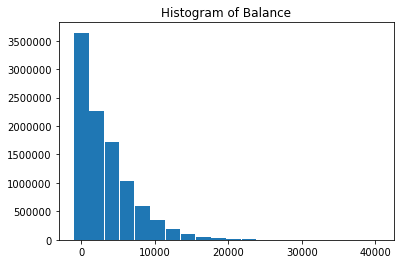

In [22]:
#then using matplotlib:
plt.bar(data['bins'],data['freq'],width=2000)
plt.title("Histogram of Balance")
#highly skewed towards right. apply boxcox transformation?

In [23]:
#scatter plot. to visualize interaction between features.
#Pyspark doesn't provide any visualization module. and trying to plot billion 
#of records will be impractical; so perform sampling;

In [24]:
fraud_df.groupBy("gender").count().show()

+------+-------+
|gender|  count|
+------+-------+
|     1|6178231|
|     2|3821769|
+------+-------+



In [25]:
#numerical columns:
numerical = ['balance', 'numTrans', 'numIntlTrans']

In [26]:
#performing stratified sampling; without replacement. with fractions from 
#each strata.
#because gender is skewed.
sampled_df = fraud_df.sampleBy('gender',{1:0.0002,2:0.0002}).select(numerical)

In [28]:
#using bokeh;
sampled_df.persist().count()

1947

In [29]:
data_multi=dict([(elem,sampled_df.select(elem).rdd.flatMap(lambda row:row).collect())
                for elem in numerical])

In [32]:
data_multi

{'balance': [8000,
  4000,
  5358,
  4242,
  0,
  0,
  6508,
  308,
  6000,
  2495,
  232,
  3000,
  3137,
  0,
  0,
  11622,
  6000,
  765,
  9000,
  4551,
  4066,
  8000,
  4000,
  5544,
  5000,
  13000,
  5000,
  6474,
  6000,
  5084,
  950,
  0,
  0,
  1998,
  16497,
  5720,
  2575,
  0,
  8017,
  0,
  3592,
  0,
  7000,
  4000,
  6000,
  9000,
  1893,
  3000,
  1743,
  0,
  8000,
  0,
  0,
  6000,
  0,
  7000,
  0,
  0,
  6218,
  3000,
  4000,
  15000,
  2138,
  3000,
  6000,
  4000,
  7000,
  5572,
  7573,
  5000,
  4000,
  1106,
  5094,
  0,
  9495,
  0,
  8440,
  6604,
  1972,
  0,
  5000,
  7145,
  22000,
  2952,
  2762,
  1007,
  572,
  0,
  0,
  7000,
  6000,
  0,
  4000,
  0,
  2249,
  3000,
  3401,
  14459,
  0,
  4184,
  0,
  4000,
  3000,
  0,
  5000,
  12203,
  11000,
  4000,
  11000,
  7000,
  8891,
  4000,
  7000,
  2000,
  953,
  9731,
  3796,
  2119,
  0,
  4000,
  0,
  5089,
  6116,
  1712,
  6000,
  0,
  1947,
  4000,
  4000,
  9488,
  4000,
  2542,
  0,
  1105,
 

In [34]:
data_multi.keys()

['balance', 'numIntlTrans', 'numTrans']

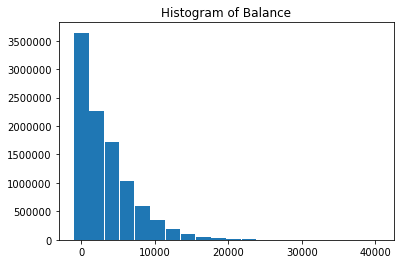

In [37]:

plt.bar(data['bins'],data['freq'],width=2000)
plt.title("Histogram of Balance")

In [35]:
sctr = chrt.Scatter(data_multi,x='balance',y='numTrans')
chrt.show(sctr)

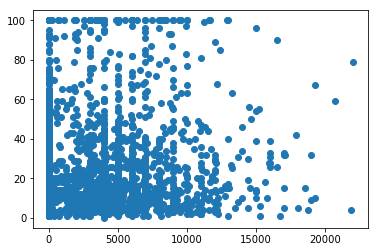

In [36]:
#to do it in matplotlib?
plt.scatter(data_multi['balance'],data_multi['numTrans'])